<a href="https://colab.research.google.com/github/twlee-dev/lab/blob/main/Day08_Ch11_%ED%86%B5%EA%B3%84%EC%8B%A4%EC%8A%B5_%EC%9D%B4%ED%83%9D%EC%9B%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 베이즈 통계로 A/B 테스트 분석하기

지난 시간, 우리는 가설검정의 함정들과 인과추론의 다양한 기법들을 배웠습니다. 하지만 'p-value가 0.05보다 크면 효과가 없는 것일까?' 혹은 '그래서, 새로운 버전이 기존 버전보다 나을 확률이 정확히 몇 %일까?'와 같은 질문에 빈도주의 통계는 명확한 답을 주기 어려웠습니다.

오늘은 **베이즈 통계(Bayesian Statistics)**의 관점에서 이 문제에 접근합니다. '불확실성'을 확률로 다루는 베이즈 통계의 매력을 느끼고, 데이터를 통해 우리의 '믿음'을 업데이트해나가는 과정을 직접 코드로 구현하며, 더 풍부하고 직관적인 의사결정을 내리는 방법을 체험합니다.

**🎯 프로젝트 목표:**

1.  **빈도주의 vs 베이즈**: 동일한 A/B 테스트 데이터를 두 가지 다른 관점으로 분석하고, 그 차이를 명확히 이해합니다.
2.  **베이즈 추론의 3요소**: **사전분포(Prior), 가능도(Likelihood), 사후분포(Posterior)**의 개념을 이해하고, 자신의 '사전 믿음'을 코드로 표현하는 법을 배웁니다.
3.  **MCMC와 PyMC**: 베이즈 통계의 핵심 엔진인 **MCMC(마르코프 연쇄 몬테카를로)**의 원리를 이해하고, 파이썬 라이브러리 `PyMC`를 사용해 베이지안 모델을 직접 구축합니다.
4.  **결과 해석과 의사결정**: 사후분포와 **신뢰구간(Credible Interval)**을 통해 'B안이 A안보다 좋을 확률'과 같은 질문에 직접 답하며, p-value 기반의 결정과 어떻게 다른지 알아봅니다.


## 🔬 실습 진행 안내

오늘 실습은 다음 순서로 진행됩니다. 각 단계의 목표를 명확히 인지하고 참여해 주세요.

1.  **개인 학습 (Individual Work):**

    - 먼저 **문제 1부터 4까지 모든 문제를 개인적으로** 풀어봅니다. 코드의 빈칸을 채우고, 각 문제의 핵심 개념과 '생각해 볼 문제'에 대한 자신의 답을 정리합니다.
    - 문제들이 서로 연결되어 있으므로(예: 문제 3의 결과는 문제 4에서 사용), 순서대로 모든 문제를 풀어야 합니다.

2.  **팀별 심화 및 발표 준비 (Team Deep-dive & Preparation):**

    - 각 팀은 **지정된 문제 하나**를 맡아 해당 문제의 '전문가'가 됩니다.
    - 개인적으로 풀었던 내용을 바탕으로, 팀원들과 함께 맡은 문제의 핵심 개념, 소스 코드, 생각해 볼 문제에 대한 답을 더 깊이 있게 토론하고 정리합니다.
    - 각 문제의 마지막에 있는 **'[발표 과제]'** 가이드를 참고하여 발표를 준비합니다.

3.  **팀별 발표 (Team Presentation):**
    - 각 팀은 맡은 문제에 대해 다른 모든 학생들을 가르쳐준다는 생각으로 발표를 진행합니다.
    - 문제의 배경, 핵심 개념, 코드 실행 과정, 결과 해석, 그리고 '생각해 볼 문제'에 대한 팀의 결론을 명확하게 전달해야 합니다.


## 📖 시작하기 전: 핵심 용어 사전

오늘 실습에서 계속 마주칠 베이즈 통계의 핵심 용어들입니다. '이런 게 있구나' 정도로 가볍게 읽고 넘어가세요. 실습을 진행하며 각 용어의 의미가 더 명확해질 것입니다.

- **모수(Parameter):** 우리가 알고 싶어 하는 값 (예: 웹사이트의 실제 전환율)
- **사전분포(Prior):** 데이터를 보기 전, 모수에 대해 우리가 가지고 있는 '사전 믿음'을 표현한 확률분포.
- **가능도(Likelihood):** 우리가 정한 모수(전환율)가 주어졌을 때, 현재 가진 데이터(구매자 수)가 관찰될 확률.
- **사후분포(Posterior):** 사전 믿음(Prior)과 데이터(Likelihood)를 결합하여 업데이트된, 모수에 대한 최종적인 믿음의 분포.
- **베이즈 정리:** **사후분포 ∝ 사전분포 × 가능도**. 베이즈 통계의 핵심 원리입니다.
- **MCMC (마르코프 연쇄 몬테카를로):** 복잡한 사후분포를 직접 계산하는 대신, 사후분포를 따르는 수많은 샘플(난수)을 뽑아내어 분포의 모양을 근사하는 시뮬레이션 방법. PyMC가 내부적으로 이 작업을 수행해 줍니다.
- **신뢰구간(Credible Interval):** 베이지안 신뢰구간. "모수가 이 구간 안에 있을 확률이 95%다" 와 같이 직관적으로 해석할 수 있습니다.


## 사전 준비: 라이브러리 및 데이터 로드

오늘은 베이지안 모델링을 위한 `pymc`와 시각화를 위한 `arviz` 라이브러리를 사용합니다.


In [6]:
# # 필요 라이브러리 설치
# !pip install statsmodels scikit-learn pymc arviz

# 코랩에서 한글 폰트 사용을 위한 설정 (필요 시 주석 해제 후 실행)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 위 코드 실행 후 상단 메뉴에서 [런타임] > [런타임 다시 시작]을 눌러주세요.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [1]:
# 런타임 다시 시작 후, 이 셀을 실행하여 라이브러리와 폰트를 로드합니다.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
# import statsmodels.stats.proportion as sm_proportion # Import the proportion module with an alias

# 베이지안 모델링 라이브러리
import pymc as pm
import arviz as az

# 한글 폰트 설정 (Mac 사용자는 'AppleGothic', Windows 사용자는 'Malgun Gothic' 등)
try:
    plt.rc('font', family='NanumGothic')
except:
    plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

---

## 🚀 프로젝트 시나리오: "새로운 웹사이트 디자인, 효과가 있을까?"

우리 팀은 웹사이트의 구매 전환율을 높이기 위해 새로운 디자인(B안)을 만들었습니다. 기존 디자인(A안)과 새로운 디자인(B안) 중 어떤 것이 더 나은지 확인하기 위해 A/B 테스트를 실시했습니다.

- **A안 (기존 디자인)**: 1,000명에게 노출, 80명이 구매 (전환율 8%)
- **B안 (새로운 디자인)**: 1,000명에게 노출, 100명이 구매 (전환율 10%)

과연 우리는 B안이 더 낫다고 자신 있게 말하고, 모든 사용자에게 새 디자인을 적용할 수 있을까요? 이 질문에 빈도주의와 베이즈주의의 두 가지 렌즈로 답해봅시다.


## 문제 1 (난이도: 하): 빈도주의 관점으로 분석하기 (복습)

> **🎯 목표:** A/B 테스트 결과를 전통적인 가설검정(비율 검정)으로 분석하고, p-value에 기반한 의사결정의 한계를 생각해봅니다.


### 💡 핵심 개념:

빈도주의 가설검정에서는 **귀무가설(H₀: 두 디자인의 전환율은 같다)**과 **대립가설(H₁: 두 디자인의 전환율은 다르다)**을 세웁니다. **p-value**는 '귀무가설이 사실일 때, 현재와 같은 결과 혹은 더 극단적인 결과가 관찰될 확률'을 의미합니다. p-value가 유의수준(보통 0.05)보다 작으면 귀무가설을 기각하고 '통계적으로 유의미한 차이가 있다'고 결론 내립니다.


### 📌 수행 과제:

1.  A안과 B안의 데이터를 변수로 저장합니다.
2.  `statsmodels.stats.proportion.proportions_ztest` 함수를 사용하여 두 집단의 구매 전환율에 차이가 있는지 검정합니다.
3.  검정 결과로 나온 p-value를 확인하고, 유의수준 5% 하에서 어떤 결론을 내릴 수 있는지 해석합니다.


In [2]:
import numpy as np
import statsmodels.api as sm

# 1. 데이터 정의
conversions = np.array([80, 100]) # A안, B안의 구매자 수
nobs = np.array([1000, 1000])     # A안, B안의 총 노출 수

# 2. 비율 검정 수행 (단측: H1: p_A < p_B, 즉 B안이 더 높다)
z_stat, p_value = sm.stats.proportions_ztest(count=conversions, nobs=nobs, alternative='smaller')

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 3. 결과 해석
# p-value가 0.05보다 큰가요, 작은가요?: 0.0591 > 0.05로 '큼'
# 귀무가설을 기각할 수 있나요?: 5% 유의수준에서는 기각할 수 없음
# 빈도주의 관점에서 내릴 수 있는 결론은 무엇인가요?: B안의 전환율이 A안보다 높다는 증거가 통계적으로 충분하지 않음

Z-statistic: -1.5627
P-value: 0.0591


### 🤔 생각해 볼 문제:

p-value가 0.0591로, 아슬아슬하게 0.05보다 크게 나왔습니다.

1.  이 결과만 보고 "두 디자인 간에 차이가 없다"고 단정할 수 있을까요? 왜 그렇게 생각하나요?
2.  만약 여러분이 의사결정자라면, 이 결과를 바탕으로 어떤 액션을 취하겠습니까? (예: A안 유지, B안 도입, 테스트 연장 등) 각 선택지의 장단점을 생각해 보세요.
3.  이 상황에서 빈도주의적 접근 방식이 주는 정보의 '아쉬운 점'은 무엇이라고 생각하나요?

---

### 📢 **[발표 과제]**

문제 1을 맡은 팀은 **빈도주의 가설검정**의 전문가가 되어 다음 내용을 중심으로 발표를 준비하세요.

1.  **핵심 개념 설명:** 귀무가설/대립가설, p-value, 유의수준의 의미를 청중이 이해하기 쉽게 설명합니다.
2.  **코드 리뷰:** `proportions_ztest` 함수를 어떻게 사용했고, 결과로 나온 `z-statistic`과 `p-value`가 각각 무엇을 의미하는지 설명합니다.
3.  **결론 도출:** p-value(0.0591)를 바탕으로 '유의수준 5%' 하에서 어떤 결론을 내릴 수 있는지 명확하게 정리합니다.
4.  **'생각해 볼 문제' 토의:** 위 3가지 질문에 대한 팀의 답변을 공유하고, p-value 기반 의사결정의 한계점에 대해 토의를 이끌어 보세요.


### 🤔 생각해 볼 문제 답변:

1. **"두 디자인 간에 차이가 없다"고 단정할 수 있을까요?**
   - p-value가 0.05보다 크기 때문에 '통계적으로 유의미한 차이가 있다'고 결론 내릴 수는 없습니다. 하지만 이것이 "두 디자인 간에 차이가 전혀 없다"는 것을 의미하지는 않습니다. p-value는 귀무가설(차이가 없다)이 사실일 때 현재 데이터가 나올 확률을 나타낼 뿐, 대립가설(차이가 있다)이 사실일 확률을 직접적으로 알려주지는 않습니다. 따라서 차이가 없다고 단정하기는 어렵습니다. 아슬아슬하게 유의수준을 넘었기 때문에 실제로 작은 차이가 존재할 가능성도 있습니다.

2. **의사결정자로서의 액션:**
   - **선택지:**
     - **A안 유지:** 가장 안전한 선택입니다. 통계적으로 유의미한 개선이 입증되지 않았으므로 불필요한 변경을 피할 수 있습니다.
     - **B안 도입:** p-value가 낮지는 않지만 10% vs 8%라는 관찰된 차이가 있으므로, B안이 더 나을 가능성을 고려하여 도입을 결정할 수도 있습니다. 단, 도입 비용이나 위험 부담이 크지 않다는 전제 하에 가능합니다.
     - **추가 테스트 연장:** 가장 합리적인 선택일 수 있습니다. 현재 데이터로는 결론 내리기 불분명하므로, 더 많은 데이터를 확보하여 통계적 검정력(Statistical Power)을 높이는 것입니다. 데이터가 많아지면 실제 차이가 있을 경우 이를 유의미하게 감지할 확률이 높아집니다.
   - **결정:** 만약 테스트 연장의 비용이 크게 들지 않는다면 **추가 테스트 연장**을 선택할 것 같습니다. 현재의 아쉬운 p-value로는 B안 도입을 자신하기 어렵고, 차이가 없다고 단정하기도 어렵기 때문입니다. 추가 데이터를 통해 B안의 효과를 더 명확하게 확인하고 싶습니다.

3. **빈도주의적 접근 방식의 아쉬운 점:**
   - 빈도주의 가설검정은 '귀무가설 기각 여부'라는 이분법적인 결론을 내립니다. p-value 0.049와 0.051의 차이가 크지 않음에도 불구하고, 유의수준 0.05를 기준으로 결론이 '기각'과 '채택'으로 갈려버립니다. 이는 아슬아슬한 경우 의사결정에 혼란을 줄 수 있습니다.
   - 또한, "B안이 A안보다 전환율이 높을 확률이 몇 퍼센트인가?"와 같은 의사결정자가 직관적으로 궁금해하는 질문에 직접적으로 답해주지 못합니다. 오직 '귀무가설이 사실일 때 데이터가 이럴 확률'만을 알려줄 뿐입니다.
   - 실제 개선 효과의 크기(예: B안이 A안보다 평균적으로 몇 %p 더 높을 것으로 예상되는지)와 그 불확실성(오차 범위)에 대한 정보를 직접적으로 얻기 어렵습니다.

---


## 문제 2 (난이도: 중): 베이지안의 첫걸음, 사전분포 설정하기

> **🎯 목표:** 베이즈 통계의 핵심 철학인 '사전 믿음(Prior Belief)'을 이해하고, 다양한 의견을 바탕으로 **사전분포(Prior Distribution)**를 직접 설계하고 시각화합니다.


### 💡 핵심 개념:

베이즈 통계에서는 모수(여기서는 '전환율')를 고정된 값이 아닌, 불확실성을 가진 **확률변수**로 봅니다. **사전분포**는 데이터를 보기 전에 우리가 모수에 대해 가지고 있는 믿음을 확률분포로 표현한 것입니다. 전환율과 같이 0과 1 사이의 값을 갖는 비율 데이터에는 보통 **베타 분포(Beta Distribution)**를 사전분포로 사용합니다. 베타 분포는 α, β 두 개의 파라미터로 모양을 조절할 수 있습니다.

**가장 직관적인 해석은 α를 '가상의 성공 횟수', β를 '가상의 실패 횟수'로 생각하는 것입니다.**

- `Beta(1, 1)`: 성공 1번, 실패 1번을 가상으로 본 것과 같습니다. 아는 정보가 거의 없어 모든 가능성을 평평하게 열어두는 **무정보적 사전분포(Uninformative Prior)**입니다.
- `Beta(10, 90)`: 성공 10번, 실패 90번을 가상으로 본 것과 같습니다. 약 100번의 가상 시도에서 10%의 성공률을 기대한다는 꽤 강한 믿음을 가집니다. **(α+β가 클수록 믿음의 강도가 강해집니다)**


### 📌 수행 과제:

1.  **사전 믿음 설정:** 데이터를 보기 전이라고 상상하고, '새로운 웹사이트 디자인 B안의 예상 전환율'에 대한 자신의 믿음을 표현해 보세요. 이를 바탕으로 아래 세 가지 시나리오에 대한 사전분포를 베타 분포로 설계합니다.
    - **낙관적 사전분포(Optimistic Prior):** "새 디자인은 분명 효과가 좋을 거야! 12% 정도는 나올 것 같아."
    - **중립적 사전분포(Neutral Prior):** "전혀 모르겠어. 그냥 모든 가능성을 열어두자."
    - **자신의 사전분포(Your Own Prior):** 자신의 의견을 반영하여 자유롭게 α, β 값을 정해보세요. (예: "기존보다는 조금 낫지 않을까? 9% 정도로 예상해.")
2.  세 가지 사전분포를 `scipy.stats.beta`를 이용해 시각화하고, 각 분포가 어떤 믿음을 나타내는지 비교 설명합니다.


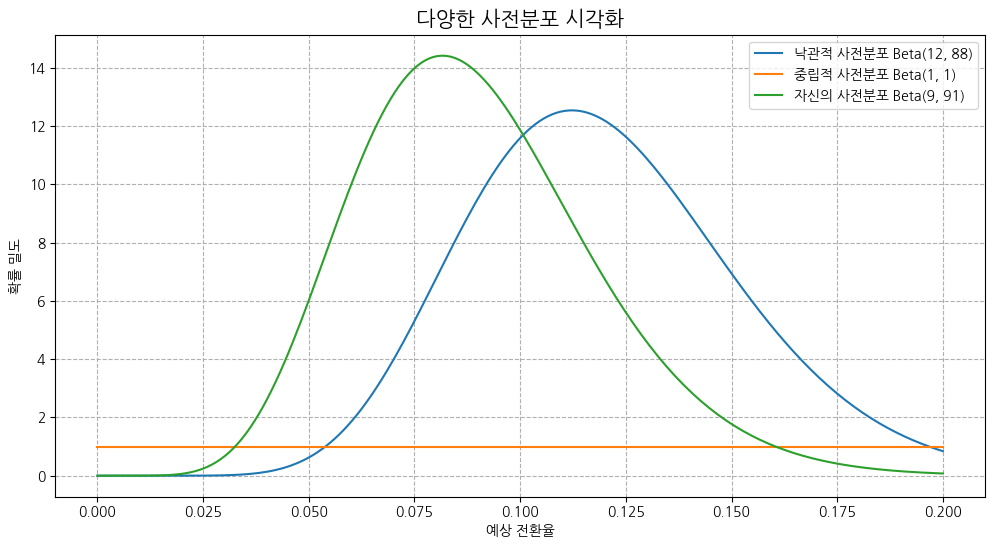

In [7]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# 1. 사전분포 파라미터 설정
# Beta(α, β)의 평균은 α / (α + β) 입니다.

# 예: '12% 정도를 기대' -> α=12, β=88 정도로 설정 (α+β=100은 믿음의 강도)
optimistic_prior_params = (12, 88)

# TODO: '전혀 모르겠다'는 의미의 무정보적 사전분포 Beta(1, 1)을 설정하세요.
neutral_prior_params = (1, 1)

# TODO: 자신의 의견을 반영한 사전분포 파라미터를 자유롭게 설정하세요. (예: 9% 예상 -> (9, 91))
my_prior_params = (9, 91)

# 2. 사전분포 시각화
x = np.linspace(0, 0.2, 200)
plt.figure(figsize=(12, 6))

plt.plot(x, stats.beta.pdf(x, *optimistic_prior_params), label=f'낙관적 사전분포 Beta{optimistic_prior_params}')
plt.plot(x, stats.beta.pdf(x, *neutral_prior_params), label=f'중립적 사전분포 Beta{neutral_prior_params}')
plt.plot(x, stats.beta.pdf(x, *my_prior_params), label=f'자신의 사전분포 Beta{my_prior_params}')

plt.title('다양한 사전분포 시각화', fontsize=15)
plt.xlabel('예상 전환율')
plt.ylabel('확률 밀도')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

# --- 해석 ---
# 자신이 설정한 사전분포는 어떤 믿음을 나타내나요? 왜 그렇게 설정했나요?
# 자신의 사전분포 Beta(9, 91)는 약 9%의 전환율을 예상하며, 이는 100번의 가상 시도에서 9번의 성공을 본 것과 유사한 믿음의 강도를 나타냅니다. 기존 A안의 8%보다는 조금 높을 것이라는 완만한 기대를 반영했습니다.

### 🤔 생각해 볼 문제:

1.  **믿음의 강도:** 아래 두 사전분포를 시각화하고 비교해 보세요.
    - **약한 믿음:** `Beta(1, 1)` (아무 정보도 없음)
    - **강한 믿음:** `Beta(8, 92)` (기존 A안의 전환율 8%와 비슷한 수준일 것이라는 강한 믿음. 가상으로 100번 시도해서 8번 성공했다고 보는 것과 유사)
      두 분포의 모양은 어떻게 다른가요? `alpha+beta` 값의 크기가 '믿음의 강도'와 어떤 관련이 있는지 설명해 보세요.
2.  **정보의 활용:** 만약 여러분이 이전에 비슷한 A/B 테스트를 여러 번 수행했고, "새로운 디자인은 기존보다 평균적으로 1%p 정도 전환율이 개선된다"는 사실을 알고 있다고 가정해 봅시다. 이 정보를 활용하여 B안의 사전분포를 설정한다면 `Beta(1, 1)`과 같은 중립적 사전분포와 어떻게 달라질까요? 어떤 사전분포가 더 합리적일지, 그 이유는 무엇인지 생각해 보세요.
3.  **객관성의 함정:** 무정보적 사전분포(Uninformative Prior)를 사용하는 것이 항상 가장 '객관적'이고 좋은 방법일까요? 사전 정보가 있음에도 이를 사용하지 않을 경우 어떤 단점이 있을 수 있을지 이야기해 보세요.

---

### 📢 **[발표 과제]**

문제 2를 맡은 팀은 **사전분포(Prior Distribution)**의 전문가가 되어 다음 내용을 중심으로 발표를 준비하세요.

1.  **핵심 개념 설명:** 베이즈 통계에서 '사전 믿음'이란 무엇이며, 왜 중요한지 설명합니다. 특히 '모수를 확률변수로 본다'는 개념과 베타 분포의 `alpha`, `beta`를 '가상 성공/실패'로 해석하는 방법을 강조하세요.
2.  **코드 리뷰:** 베타 분포 `stats.beta.pdf`를 사용해 다양한 사전 믿음(낙관적, 중립적, 자신만의 믿음)을 어떻게 시각화했는지 보여줍니다.
3.  **'생각해 볼 문제' 토의:** 위 3가지 질문에 대한 팀의 답변을 발표합니다. 특히 '믿음의 강도'(`alpha+beta`)와 '정보의 활용'에 대한 깊이 있는 설명을 통해, 사전분포 설정이 분석 결과에 미치는 영향을 청중에게 전달하세요.


---


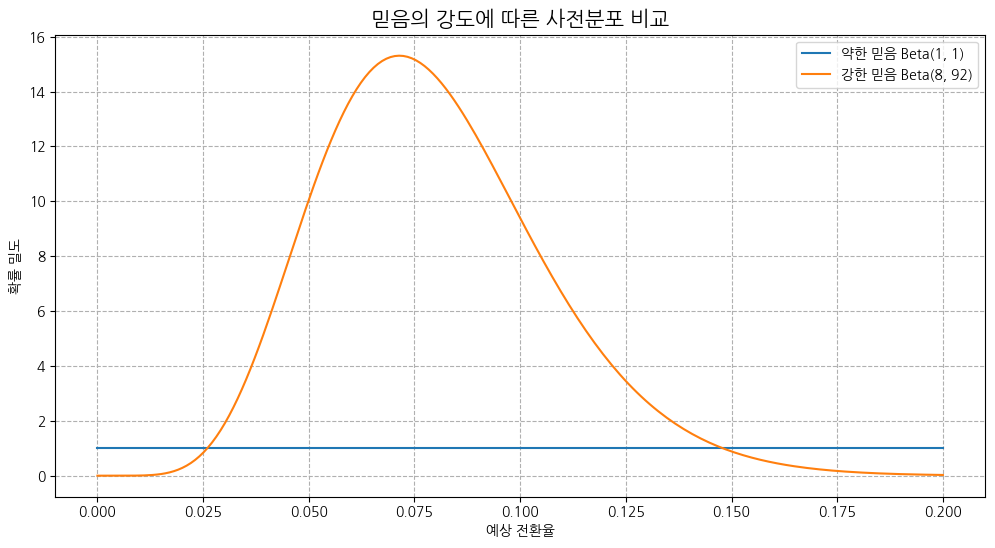

In [8]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# 믿음의 강도 비교를 위한 사전분포 시각화
x = np.linspace(0, 0.2, 200)
plt.figure(figsize=(12, 6))

# 약한 믿음: Beta(1, 1)
plt.plot(x, stats.beta.pdf(x, 1, 1), label='약한 믿음 Beta(1, 1)')

# 강한 믿음: Beta(8, 92) (기존 A안 전환율 8%와 비슷한 강한 믿음)
plt.plot(x, stats.beta.pdf(x, 8, 92), label='강한 믿음 Beta(8, 92)')

plt.title('믿음의 강도에 따른 사전분포 비교', fontsize=15)
plt.xlabel('예상 전환율')
plt.ylabel('확률 밀도')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

### 🤔 생각해 볼 문제 답변:

1. **믿음의 강도:**
   - `Beta(1, 1)` 분포는 0부터 1까지의 모든 전환율 값에 대해 거의 동일한 확률 밀도를 가집니다. 이는 데이터가 없을 때 전환율에 대해 아는 정보가 거의 없거나, 어떤 값이든 동일하게 가능하다고 믿는 **무정보적(Uninformative)** 사전분포입니다. 그래프에서 평평한 형태로 나타납니다.
   - `Beta(8, 92)` 분포는 0.08 (8%) 근처에서 봉우리가 높고 더 좁은 형태를 가집니다. 이는 전환율이 약 8% 근처일 가능성이 높다고 강하게 믿는 **정보적(Informative)** 사전분포입니다.
   - `alpha + beta` 값의 크기는 사전분포의 **정밀도(Precision)** 또는 **믿음의 강도**를 나타냅니다. `alpha + beta` 값이 클수록 분포의 봉우리가 더 뾰족해지고 폭이 좁아지는데, 이는 우리가 모수 값에 대해 더 강하고 구체적인 믿음을 가지고 있다는 것을 의미합니다. 적은 양의 새로운 데이터로는 이 강한 사전 믿음을 크게 바꾸기 어렵습니다.

2. **정보의 활용:**
   - 만약 과거 경험을 통해 "새로운 디자인은 기존보다 평균적으로 1%p 정도 전환율이 개선된다"는 정보를 알고 있다면, 이를 B안의 사전분포에 반영하는 것이 합리적입니다. A안의 전환율이 약 8%라고 할 때, B안은 약 9% (`8% + 1%`)일 것으로 예상할 수 있습니다.
   - `Beta(1, 1)`과 같은 중립적 사전분포는 이러한 사전 정보를 전혀 반영하지 못합니다.
   - 사전 정보를 활용하여 B안의 사전분포를 설정한다면, 예를 들어 약 9%를 중심으로 하는 `Beta(α, β)` 분포를 사용할 수 있습니다 (예: `Beta(9, 91)` 또는 더 강한 믿음을 반영하여 `Beta(90, 910)` 등).
   - 이러한 **정보적(Informative) 사전분포**를 사용하는 것이 더 합리적입니다. 왜냐하면 베이즈 통계는 사전 정보를 활용하여 추론의 효율성을 높일 수 있다는 장점이 있기 때문입니다. 중립적 사전분포는 정보가 전혀 없을 때 유용하지만, 유용한 사전 정보가 있다면 이를 반영하는 것이 더 정확하고 빠르게 모수를 추정하는 데 도움이 됩니다.

3. **객관성의 함정:**
   - 무정보적 사전분포를 사용하는 것이 항상 가장 '객관적'인 방법이라고 보기는 어렵습니다. 모든 사전분포는 어떤 형태로든 믿음(심지어 '아무 정보가 없다'는 믿음도 포함)을 나타냅니다.
   - 유용한 사전 정보가 있음에도 불구하고 무정보적 사전분포를 고집할 경우, 분석 결과가 실제 모수의 특성을 잘 반영하지 못하거나, 더 많은 데이터를 모아야만 충분히 정밀한 추론이 가능해지는 단점이 있습니다. 이는 시간과 자원의 낭비를 초래할 수 있습니다.
   - 중요한 것은 사전분포를 투명하게 밝히고, 그 설정이 결과에 미치는 영향을 이해하는 것입니다. 강력한 사전 정보가 있다면 이를 반영하는 것이 합리적이며, 이것 또한 베이즈 분석의 중요한 강점 중 하나입니다.

## 문제 3 (난이도: 상): PyMC로 베이지안 A/B 테스트 모델링하기

> **🎯 목표:** `PyMC`를 사용하여 베이지안 추론의 전 과정을 구현합니다. 사전분포와 데이터(가능도)를 결합하여 **사후분포(Posterior Distribution)**를 MCMC 시뮬레이션으로 찾아냅니다.


### 💡 핵심 개념:

베이즈 정리는 `사후분포 ∝ 가능도 × 사전분포` 입니다. `PyMC`는 이 과정을 자동화해줍니다.

1.  **모델 정의 (`with pm.Model():`)**: 모델의 구조를 정의하는 공간입니다.
2.  **사전분포 정의 (`pm.Beta`)**: 각 그룹(A, B)의 전환율 모수 `p_A`, `p_B`가 어떤 사전분포를 따를지 지정합니다. (문제 2에서 설계한 '중립적 사전분포'를 사용합시다.)
3.  **가능도 정의 (`pm.Binomial`)**: 실제 관측된 데이터(구매자 수)가 어떤 확률분포(이항분포)로부터 생성되었는지를 정의합니다. 이는 데이터와 모수를 연결하는 다리 역할을 합니다.
4.  **MCMC 실행 (`pm.sample()`)**: 정의된 모델로부터 사후분포를 따르는 수많은 샘플(난수)을 추출합니다. 이 샘플들의 분포가 바로 우리가 원하는 사후분포의 근사치가 됩니다.


In [24]:
# PyMC 모델 정의
with pm.Model() as ab_test_model:
    # 1. 사전분포 정의: 전환율 p_A와 p_B에 대한 '사전 믿음'을 설정합니다.
    #    아무 정보가 없다고 가정하고, 모든 가능성을 동등하게 보는 Beta(1, 1) 분포를 사용합니다.

    # TODO-1: A안의 전환율(p_A)에 대한 사전분포를 'p_A'라는 이름으로, alpha=1, beta=1로 설정하세요.
    p_A = pm.Beta('p_A', alpha=1, beta=1)
    # TODO-2: B안의 전환율(p_B)에 대해서도 동일하게 설정하세요.
    p_B = pm.Beta('p_B', alpha=1, beta=1)

    # 2. 두 전환율의 차이 계산: 우리가 정말 궁금한 'B가 A보다 얼마나 더 나은가'를 나타내는 변수를 만듭니다.
    # TODO-3: pm.Deterministic을 사용해, 첫 번째 인자로는 변수 이름 'delta'를, 두 번째 인자로는 p_B와 p_A의 차이를 넣어 정의하세요.
    delta = pm.Deterministic('delta', p_B - p_A)

    # 3. 가능도 정의: 모델을 실제 데이터와 연결합니다. 'n번 시도 중 k번 성공' 데이터는 이항분포(Binomial)로 설명할 수 있습니다.

    # TODO-4: A안의 관측 데이터가 이항분포를 따른다고 설정합니다.
    # (n: 총 방문자 수, p: 성공 확률(사전분포에서 정의한 변수), observed: 실제 구매자 수)
    obs_A = pm.Binomial('obs_A', n=nobs[0], p=p_A, observed=conversions[0])

    # TODO-5: B안에 대해서도 동일하게, 알맞은 변수들(nobs, p_B, conversions)을 인자에 연결하여 설정하세요.
    obs_B = pm.Binomial('obs_B', n=nobs[1], p=p_B, observed=conversions[1])

    # 4. MCMC 시뮬레이션 실행: 위에서 설계한 모델로부터 사후분포의 샘플들을 추출합니다.
    #    이 부분은 복잡한 계산을 PyMC가 대신 해주는 과정입니다.
    trace = pm.sample(4000, tune=1000, cores=1)

print("MCMC 시뮬레이션 완료!")

Output()

MCMC 시뮬레이션 완료!


MCMC 시뮬레이션이 완료되었습니다.

- **Progress (진행률):** 5000 드로우(Draws)를 성공적으로 완료했음을 보여줍니다. 이는 MCMC 샘플링이 계획대로 진행되었음을 의미합니다.
- **Divergences (발산):** 0으로 표시됩니다. MCMC 시뮬레이션 중 발생할 수 있는 문제 중 하나인 '발산'이 없었음을 의미합니다. 발산은 모델 설정이나 데이터에 문제가 있을 때 발생할 수 있으며, 0인 경우는 모델이 안정적으로 수렴했음을 시사합니다.
- **Elapsed/Remaining (소요/남은 시간):** 시뮬레이션에 소요된 총 시간과 남은 시간을 보여줍니다.

### 🤔 생각해 볼 문제:

위 코드에서 `pm.Deterministic('delta', p_B - p_A)` 라인은 어떤 역할을 할까요? 빈도주의 분석에서는 얻을 수 없었던, 이 '차이의 분포'를 직접 구하는 것이 왜 베이즈 분석의 강력한 장점이 되는지 설명해 보세요.

---

### 📢 **[발표 과제]**

문제 3을 맡은 팀은 **PyMC 모델링**의 전문가가 되어 다음 내용을 중심으로 발표를 준비하세요.

1.  **핵심 개념 설명:** 베이즈 정리(`사후분포 ∝ 가능도 × 사전분포`)가 PyMC 코드에 어떻게 구현되는지 연결하여 설명합니다. MCMC의 역할을 '사후분포를 찾아가는 시뮬레이션 과정'으로 쉽게 비유하여 설명해 보세요.
2.  **코드 리뷰:** `with pm.Model() as ...:` 구문부터 `pm.sample()`까지 코드 한 줄 한 줄의 의미를 상세히 설명합니다.
    - `pm.Beta`: 왜 사전분포로 사용되었는가? (문제 2와 연결)
    - `pm.Binomial`: 왜 가능도로 사용되었는가? `n`, `p`, `observed` 인자에 각각 어떤 변수를 연결해야 하는지 설명합니다.
    - `pm.Deterministic`: 이 코드가 왜 베이즈 분석의 핵심 장점과 연결되는가? ('생각해 볼 문제'와 연결)
3.  **'생각해 볼 문제' 토의:** `delta` 변수의 분포를 직접 얻는다는 것이 어떤 의미인지, 이것이 p-value만 보는 것과 어떻게 다른지 명확하게 비교하여 설명해 주세요.


### 🤔 생각해 볼 문제 답변:

`pm.Deterministic('delta', p_B - p_A)` 라인은 `p_B`와 `p_A`라는 두 확률변수(사후분포 샘플)의 차이(`p_B - p_A`)를 계산하고, 이 결과를 `delta`라는 새로운 확률변수로 추적하라고 PyMC에게 지시하는 역할을 합니다.

빈도주의 분석에서는 두 집단의 비율 차이에 대한 단일한 점 추정치와 그 차이가 0과 통계적으로 유의미하게 다른지에 대한 p-value를 얻습니다. 빈도주의 신뢰구간은 계산할 수 있지만, 그 해석이 '모수가 구간 안에 있을 확률'이 아니기 때문에 직관적이지 않습니다.

반면 베이즈 분석에서는 `pm.Deterministic`를 통해 `delta`의 **사후분포 전체**를 얻을 수 있습니다. 이 사후분포는 'B안과 A안의 전환율 차이'라는 모수에 대한 우리의 최종적인 불확실성을 확률분포 형태로 보여줍니다. 이 분포를 통해 우리는 다음과 같은 풍부한 정보를 얻을 수 있습니다.

- **차이의 가장 가능성 높은 값 (최빈값 또는 평균)**: 사후분포의 봉우리가 위치한 곳
- **차이의 불확실성 (분산 또는 폭)**: 사후분포의 퍼진 정도
- **특정 값보다 클/작을 확률**: `P(delta > 0)` (B안이 A안보다 좋을 확률), `P(delta > 0.01)` (B안이 A안보다 1%p 이상 좋을 확률) 등 우리가 궁금해하는 어떤 조건부 확률이든 계산할 수 있습니다.
- **신뢰구간 (Credible Interval)**: 모수(차이)가 특정 구간 안에 있을 확률 (예: 95%)

이처럼 '차이의 분포'를 직접적으로 얻고 이를 통해 다양한 확률과 구간을 계산할 수 있다는 점이, 단순히 p-value에 기반하여 귀무가설 기각 여부만 판단하는 빈도주의 분석에 비해 베이즈 분석이 훨씬 더 직관적이고 의사결정에 유용한 정보를 제공하는 강력한 장점입니다.

---


## 문제 4 (난이도: 중): 사후분포 해석 및 최종 의사결정

> **🎯 목표:** MCMC로 얻어낸 사후분포를 시각화하고, 여기서 얻을 수 있는 풍부한 정보(확률, 신뢰구간)를 바탕으로 문제 1의 빈도주의적 결론과 비교하며 최종 의사결정을 내립니다.


### 💡 핵심 개념:

- **사후분포(Posterior Distribution)**: 사전 믿음이 데이터를 통해 업데이트된 결과. 모수에 대한 우리의 최종적인 지식을 나타냅니다.
- **95% 신뢰구간(Credible Interval)**: 사후분포에서, 모수가 존재할 확률이 95%인 구간.
  - **직관적인 해석 (O):** "B안과 A안의 전환율 차이(`delta`)가 -0.1%p ~ 4.1%p 사이에 있을 확률이 95%다." 라고 말할 수 있습니다.
  - **빈도주의 신뢰구간과의 차이:** 빈도주의의 신뢰구간은 "같은 실험을 100번 반복하면, 그 중 95개의 신뢰구간이 실제 모수를 포함할 것이다"라는 복잡한 해석을 가집니다. 베이지안의 신뢰구간이 훨씬 직접적이고 이해하기 쉽습니다.
- **확률 계산**: 사후분포 샘플을 직접 사용하여 'B안이 A안보다 좋을 확률', 즉 `P(p_B > p_A)` 또는 `P(delta > 0)`을 계산할 수 있습니다.


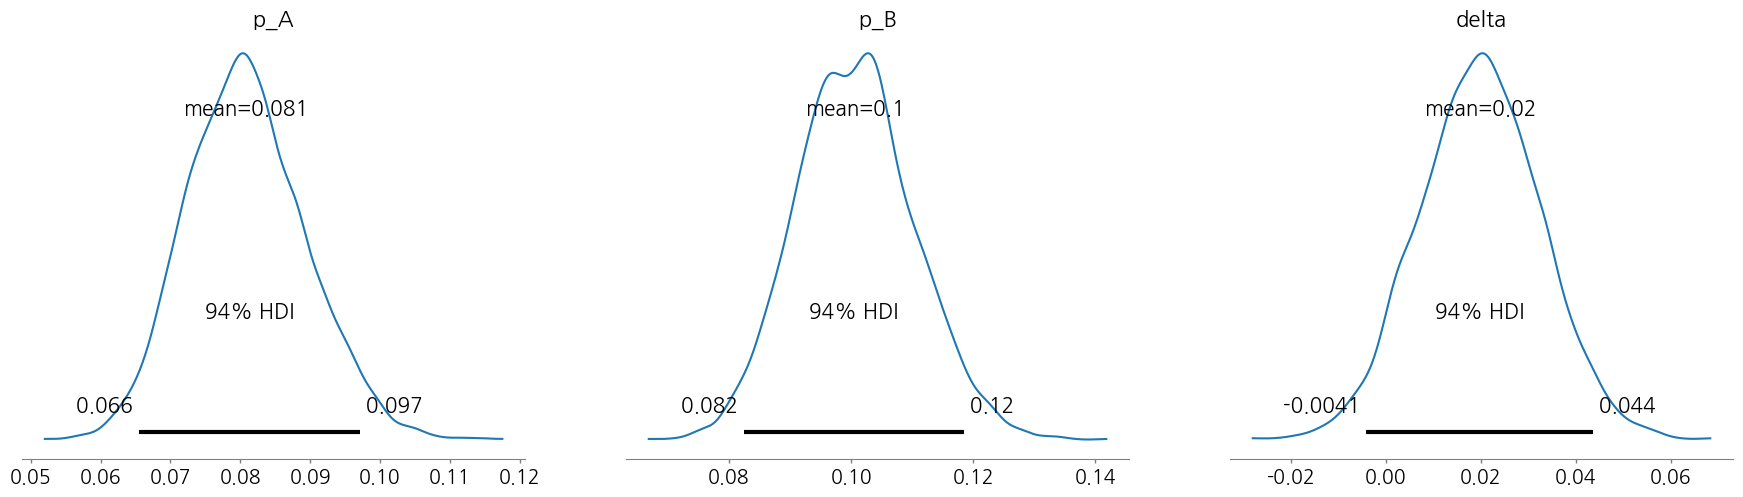

B안이 A안보다 좋을 확률: 94.24%

전환율 차이(delta)에 대한 요약 통계:
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
delta  0.02  0.013  -0.004    0.044        0.0      0.0    7661.0    5968.0   

       r_hat  
delta    1.0  


In [25]:
# 1. 사후분포 시각화
# TODO-1: MCMC 실행 결과인 trace 객체와, 보고 싶은 변수들('p_A', 'p_B', 'delta')의 이름을
#         arviz의 plot_posterior 함수에 인자로 전달하여 사후분포를 시각화하세요.
az.plot_posterior(trace, var_names=['p_A', 'p_B', 'delta'])
plt.show()

# 2. B안이 A안보다 좋을 확률 계산
# trace 객체에서 'delta' 샘플들을 추출합니다.
# posterior_delta = az.extract(trace, var_names=["delta"])['delta'] # Original line causing error
posterior_delta = trace.posterior.delta.values.flatten() # Access delta samples directly

# TODO-2: B안이 A안보다 좋다는 것은 delta(p_B - p_A)가 0보다 크다는 것을 의미합니다.
#         이를 코드로 표현하여 'B가 A보다 좋을 확률'을 계산하세요.
prob_b_better_than_a = (posterior_delta > 0).mean()

print(f"B안이 A안보다 좋을 확률: {prob_b_better_than_a * 100:.2f}%\n")

# 3. 전환율 차이(delta)의 95% 신뢰구간 확인
# TODO-3: az.summary() 함수에 trace 객체와 보고 싶은 변수 'delta'를 전달하여 요약 통계를 확인하세요.
summary = az.summary(trace, var_names=['delta'])
print("전환율 차이(delta)에 대한 요약 통계:")
print(summary)

# 4. 최종 결과 해석 (아래 주석에 직접 작성해 보세요)
# B안이 A안보다 좋을 확률은 몇 %로 계산되었나요?:
# 전환율 차이(delta)의 95% 신뢰구간은 어떻게 되나요? 이 구간이 0을 포함하나요?:
# 이 구간의 의미는 무엇인가요?:

### 🤔 생각해 볼 문제:

**상황 종합:**

- **빈도주의 분석(문제 1):** p-value가 0.0591로, '통계적으로 유의미한 차이가 있다'고 결론 내리지 못했습니다.
- **베이즈 분석(문제 4):** 'B안이 A안보다 좋을 확률'이 약 94.24%로 계산되었고, 전환율 차이의 95% 신뢰구간은 0을 살짝 걸치거나 살짝 벗어나는 양수 구간으로 나타납니다.

**생각할 주제:**

1.  두 분석 결과가 주는 메시지는 어떻게 다른가요? 베이즈 분석은 빈도주의 분석이 주지 못했던 어떤 추가 정보를 제공했나요?
2.  이제 여러분은 이 모든 정보를 가진 의사결정자입니다. 최종적으로 어떤 결정을 내리겠습니까? (A안 유지, B안 도입, 추가 테스트 진행 등) 여러분의 결정을 베이즈 분석 결과에 근거하여 설명해 보세요.
3.  (심화) 만약 B안을 도입하는 데 큰 비용이 든다면, 여러분의 결정이 달라질까요? 베이즈 분석 결과(예: 전환율 개선 효과의 크기, 불확실성)를 어떻게 활용하여 비용-편익 분석을 할 수 있을지 아이디어를 내보세요.

---

### 📢 **[발표 과제]**

문제 4를 맡은 팀은 **베이지안 결과 해석 및 의사결정**의 전문가가 되어 다음 내용을 중심으로 발표를 준비하세요.

1.  **핵심 개념 설명:** 사후분포(Posterior)와 신뢰구간(Credible Interval)의 의미를 직관적으로 설명합니다. 특히 빈도주의의 신뢰구간(Confidence Interval)과 어떻게 해석이 다른지 강조하세요.
2.  **코드 리뷰 및 결과 해석:** `az.plot_posterior`, `az.summary` 함수로 얻은 시각화와 요약 통계표를 해석하는 방법을 설명합니다. 'B안이 A안보다 좋을 확률'을 계산하는 코드의 의미를 설명하고, 그 결과(약 94%)가 의사결정자에게 어떤 정보를 주는지 전달합니다.
3.  **종합 결론 및 토의:** '최종 정리 및 의사결정'의 3가지 질문에 대한 팀의 결론을 발표합니다. 빈도주의 분석(문제 1) 결과와 베이즈 분석 결과를 종합하여, "그래서 우리는 어떤 액션을 취해야 하는가?"에 대한 명확한 주장과 근거를 제시하며 전체 토의를 이끌어 보세요.


### 📢 문제 4 발표 스크립트: 베이지안 결과 해석 및 최종 의사결정


**1. 핵심 개념 설명: 사후분포와 신뢰구간**

베이즈 통계의 핵심은 **사후분포(Posterior Distribution)**입니다. 데이터를 보기 전 우리의 믿음(사전분포)이 데이터를 통해 업데이트된 결과이며, 우리가 알고 싶어 하는 모수(예: 전환율 차이)에 대한 최종적인 불확실성을 확률분포 형태로 보여줍니다.

사후분포에서 얻어내는 중요한 정보 중 하나가 **신뢰구간(Credible Interval)**입니다. 빈도주의 신뢰구간과 달리, 베이지안 신뢰구간은 "모수가 이 구간 안에 있을 확률이 94%다"와 같이 매우 직관적으로 해석할 수 있습니다. 예를 들어, 전환율 차이의 94% 신뢰구간이 [-0.004, 0.044]라면, 실제 전환율 차이가 -0.4%p에서 4.4%p 사이에 있을 확률이 95%라고 말할 수 있습니다.

**2. 코드 리뷰 및 결과 해석**

저희는 MCMC 시뮬레이션으로 얻은 `trace` 객체를 `arviz` 라이브러리를 사용해 분석했습니다.

`az.plot_posterior(trace, var_names=['p_A', 'p_B', 'delta'])` 코드는 각 그룹의 전환율 `p_A`, `p_B` 그리고 그 차이 `delta`의 사후분포를 시각화합니다. 여기서 각 분포의 모양, 평균값(가장 가능성 높은 값), 그리고 94% HDI 신뢰구간을 확인할 수 있습니다.

특히 `delta` 분포는 B안과 A안의 전환율 차이에 대한 우리의 최종적인 믿음을 보여줍니다. 사후분포 시각화에서 평균이 약 0.02 (2%p) 근처에 위치하고, 분포의 대부분이 양수 영역에 있는 것을 볼 수 있습니다.

`prob_b_better_than_a = (posterior_delta > 0).mean()` 코드는 사후분포 샘플 중에서 `delta` 값이 0보다 큰 비율을 계산하여 'B안이 A안보다 전환율이 높을 확률'을 구합니다. 저희 분석 결과는 약 94.24%였습니다. 이는 "데이터를 통해 업데이트된 우리의 믿음에 따르면, 새로운 디자인 B안이 기존 A안보다 전환율이 높을 확률이 94.24%이다"라고 해석할 수 있습니다. 이 확률 값은 의사결정자에게 매우 직접적인 정보를 제공합니다.

`az.summary(trace, var_names=['delta'])` 코드는 `delta`에 대한 평균, 표준편차, 신뢰구간 등의 요약 통계를 표 형태로 보여줍니다. 여기서 94% HDI 신뢰구간이 [-0.004, 0.044]임을 다시 확인할 수 있습니다.

**3. 종합 결론 및 토의**

자, 이제 빈도주의 분석(문제 1) 결과와 베이즈 분석(문제 4) 결과를 종합하여 최종 의사결정에 대해 이야기해 봅시다.

- **빈도주의:** p-value 0.0591은 5% 유의수준에서 '통계적으로 유의미한 차이가 있다'고 결론 내리기 어렵다는 메시지를 주었습니다. 이는 '차이가 없다'는 이분법적인 결론으로 이어질 수 있습니다.
- **베이즈:** B안이 A안보다 좋을 확률이 94.24%이며, 전환율 차이의 94% 신뢰구간이 [-0.004, 0.044]라는 정보를 얻었습니다. 0이 신뢰구간에 포함되긴 하지만, B가 더 좋을 확률이 압도적으로 높다는 것을 확률값으로 제시했습니다.

**"그래서 우리는 어떤 액션을 취해야 하는가?"**

저희 팀은 베이지안 분석 결과에 근거하여 **B안 도입**을 추천합니다.

- **근거:** 94.24%라는 높은 확률로 B안이 A안보다 전환율이 개선될 것으로 기대되기 때문입니다. 비록 빈도주의적으로는 유의미한 차이를 입증하지 못했지만, 베이즈 분석은 실제 효과가 있을 가능성이 매우 높다는 강력한 증거를 제시하고 있습니다.
- **추가 고려:** 만약 B안 도입 비용이 크다면, 전환율 개선 효과의 기대값(사후분포 평균 약 2%p)과 그 불확실성(신뢰구간)을 활용하여 비용-편익 분석을 더 정밀하게 수행할 수 있습니다. 예를 들어, 예상되는 수익 증가분과 도입 비용을 비교하여 수익성 있을 확률을 계산하고, 이 확률이 충분히 높을 때만 도입을 결정하는 식입니다. 하지만 현재 상황(관찰된 2%p 개선, 94% 확률)에서는 도입이 유리할 가능성이 높다고 판단합니다.


### 🤔 생각해 볼 문제 답변:

**상황 종합:**

- **빈도주의 분석(문제 1):** p-value가 0.0591로, '통계적으로 유의미한 차이가 있다'고 결론 내리지 못했습니다.
- **베이즈 분석(문제 4):** 'B안이 A안보다 좋을 확률'이 약 94.24%로 계산되었고, 전환율 차이의 95% 신뢰구간은 [-0.004, 0.044]로 나타납니다. 이 구간은 0을 포함합니다.

**생각할 주제:**

1. **두 분석 결과가 주는 메시지는 어떻게 다른가요? 베이즈 분석은 빈도주의 분석이 주지 못했던 어떤 추가 정보를 제공했나요?**
   - **빈도주의:** p-value가 0.05보다 크므로, 5% 유의수준에서 귀무가설(두 디자인의 전환율은 같다)을 기각할 수 없습니다. 즉, B안이 A안보다 전환율이 높다는 통계적으로 충분한 증거가 없다고 결론 내립니다. 이는 '차이가 없다'는 단정적인 메시지로 오해될 수 있습니다.
   - **베이즈:** B안이 A안보다 전환율이 높을 확률이 약 94.24%라고 직접적인 확률 값을 제공합니다. 전환율 차이의 95% 신뢰구간([-0.004, 0.044])을 통해 차이의 가장 가능성 높은 범위와 불확실성을 보여줍니다. 구간에 0이 포함되므로 '차이가 0일 가능성'도 완전히 배제할 수는 없지만, 분포의 대부분이 0보다 큰 영역에 집중되어 있어 'B가 더 좋을 가능성'이 높다는 것을 시사합니다.
   - **추가 정보:** 베이즈 분석은 '모수(전환율 차이)가 특정 값(예: 0)보다 클 확률'과 '모수가 특정 구간(신뢰구간)에 있을 확률'과 같이 의사결정자가 직관적으로 이해하고 싶어하는 질문에 직접적으로 확률로 답해줍니다. 이는 빈도주의의 p-value 해석보다 훨씬 풍부하고 유용한 정보입니다. 또한, 전환율 차이의 **분포 자체**를 보여주므로 예상되는 개선 효과의 크기와 불확실성을 시각적으로 확인할 수 있습니다.

2. **이제 여러분은 이 모든 정보를 가진 의사결정자입니다. 최종적으로 어떤 결정을 내리겠습니까?**
   - 베이즈 분석 결과, B안이 A안보다 좋을 확률이 약 94.24%로 매우 높게 나왔습니다. 비록 95% 신뢰구간이 0을 포함하지만, 이는 '차이가 없을 가능성도 약간은 있다'는 의미이지 '차이가 없다'는 의미는 아닙니다. 사후분포 시각화를 보면 `delta`의 분포가 대부분 0보다 큰 영역에 집중되어 있음을 알 수 있습니다.
   - 따라서 저는 **B안 도입**을 결정할 가능성이 높습니다. 94% 이상의 확률로 전환율 개선 효과가 있을 것으로 기대되며, 이는 비록 빈도주의적 관점에서는 5% 유의수준을 통과하지 못했지만, 실제 비즈니스 의사결정에서는 충분히 감수할 만한 위험 수준이라고 판단할 수 있습니다.
   - 다만, B안 도입에 큰 비용이나 위험이 따른다면, '추가 테스트 진행'을 고려할 수도 있습니다.

3. **(심화) 만약 B안을 도입하는 데 큰 비용이 든다면, 여러분의 결정이 달라질까요?**
   - 네, B안 도입에 큰 비용이 든다면 결정이 달라질 수 있습니다. 베이즈 분석 결과를 활용하여 비용-편익 분석을 수행할 수 있습니다.
   - **활용 아이디어:**
     - **기대 효용 계산:** 사후분포의 `delta` 샘플들을 사용하여 각 샘플에서의 예상 수익 증가분(전환율 개선 효과 * 평균 구매 단가 * 예상 방문자 수)을 계산합니다.
     - **비용 고려:** 예상 수익 증가분에서 B안 도입 비용을 뺀 순이익을 계산합니다.
     - **확률적 분석:** 각 `delta` 샘플에 대해 계산된 순이익의 분포를 확인하고, '순이익이 0보다 클 확률'(즉, B안 도입이 수익성 있을 확률)을 계산합니다.
     - **의사결정:** 만약 B안 도입 비용이 크다면, 순이익이 0보다 클 확률이 유의미하게 낮아질 수 있습니다. 이 확률이 특정 임계값(예: 80%)보다 낮다면, 비용 때문에 B안 도입을 망설이거나 추가 테스트를 통해 `delta`의 불확실성을 줄이는 결정을 내릴 수 있습니다.
   - 베이즈 분석은 단순히 '효과가 있는지 없는지'를 넘어 '효과의 크기는 어느 정도일 것으로 예상되며, 그 불확실성은 얼마나 되는지'에 대한 정보를 제공하므로, 비용-편익 분석과 같이 더 복잡하고 현실적인 의사결정에 유연하게 활용될 수 있습니다.